# Version 1

Read in the already generated master star field and photometery and then do some work to see which other stars can be normilsation stars, or not.

# Version 2

- Amend this so it works with the new subfolder file structure

In [1]:
import numpy as np

import matplotlib
matplotlib.use('TkAgg')

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit

from scipy import optimize
from astropy.time import Time

#from astropy.visualization import time_support
#from astropy.timeseries import TimeSeries

%matplotlib notebook 
import matplotlib.image as mpimg

import pandas as pd

from astropy.io import fits
from astropy.utils.data import download_file

import os
import glob
import time
from matplotlib.colors import LogNorm
from IPython import display
from IPython.display import clear_output

import random

%matplotlib inline
plt.rcParams.update({'font.size':13})

from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from astropy import units as u
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats

from astropy.wcs import WCS

# conda install -c astropy astroquery

from astroquery.astrometry_net import AstrometryNet

from astroquery.simbad import Simbad

import astropy.units as u
from astropy import coordinates

import pyvo as vo

from My_Functions import Find_stars_photometery

import warnings
warnings.filterwarnings('ignore')

from My_Functions_v3 import update_fits_header

import copy

In [ ]:
main_star    = "V* RV UMa"
file_object  = "RV_Uma"
file_nights  = ["2022_03_20","2022_03_22","2022_03_24","2023_02_23","2023_04_03"]
save_star = file_object

In [2]:
main_star    = "tyc_3023-1974-1"
file_object  = "tyc_3023-1974-1"
file_nights  = ["2023_04_02","2023_04_03"]
save_star = file_object

In [3]:
main_star    = "V* RZ Cep"
file_object  = "RZ_Cep"
save_star = file_object
file_nights  = ["2022_12_07", "2023_01_23", "2023_02_23", "2023_11_10", "2024_01_07","2024_01_18"]

In [2]:
main_star    = "V* RZ Cas"
file_object  = "RZ_Cas"
file_nights  = ["2023_03_02","2023_04_06","2023_10_14","2023_11_30"]
save_star = file_object

In [41]:
#colour_list = ["Luminance","Red","Green","Blue"]
colour_list = "Luminance"
colour_list = "Red"
colour_list = "Green"
colour_list = "Blue"

In [42]:
master_file_path = "../../BPO_Data/"+file_object+"/"+colour_list+'/'

composite_image_file = glob.glob(master_file_path+"*weighted_mean.fits")
composite_image_file = composite_image_file[0]

composite_image_file_hdr = fits.getheader(composite_image_file)
composite_photometry_file  = composite_image_file_hdr['PHOSOLVE']
composite_photometry_file_normalisation = composite_photometry_file.replace('.csv', '_normilsation.csv')

update_fits_header(composite_image_file, 'NORMPHOT', composite_photometry_file_normalisation, comment="Photometry with normilsation stars csv")


print(composite_image_file)
print(composite_photometry_file)

../../BPO_Data/RZ_Cas/Blue\Composite_RZ_Cas_B_weighted_mean.fits
../../BPO_Data/RZ_Cas/Blue/Composite_RZ_Cas_B_weighted_mean_photometry_solved.csv


In [43]:
composite_df_stars = pd.read_csv(composite_photometry_file)

In [44]:
composite_image = fits.getdata(composite_image_file)

In [45]:
my_cmap = copy.copy(matplotlib.cm.get_cmap('gray')) # copy the default cmap
my_cmap.set_bad((0,0,0))

In [46]:
list_of_non_normilation_targets = ['RRLyrae','LongPeriodV*','EclBin']

In [47]:
composite_df_stars['Normilsation_star'] = 'FALSE'
composite_df_stars['Normilsation_star_reason'] = 'Default so still to do' 

In [48]:
main_x = np.shape(composite_image)[1]/2
main_y = np.shape(composite_image)[0]/2
composite_df_stars['pixels_from_main_star'] = np.sqrt( (composite_df_stars["xcenter"]-main_x )**2 + (composite_df_stars["ycenter"] - main_y)**2 )

Let's say is the star is more then 3/4 of the way to the edge from our star we automatically mark as "too close to edge".

In [49]:
max_dist = min(np.shape(composite_image))*3/8

for ind in composite_df_stars.index:
    if composite_df_stars['pixels_from_main_star'][ind] > max_dist:
        composite_df_stars['Normilsation_star_reason'][ind] = 'Auto - too far from centre'

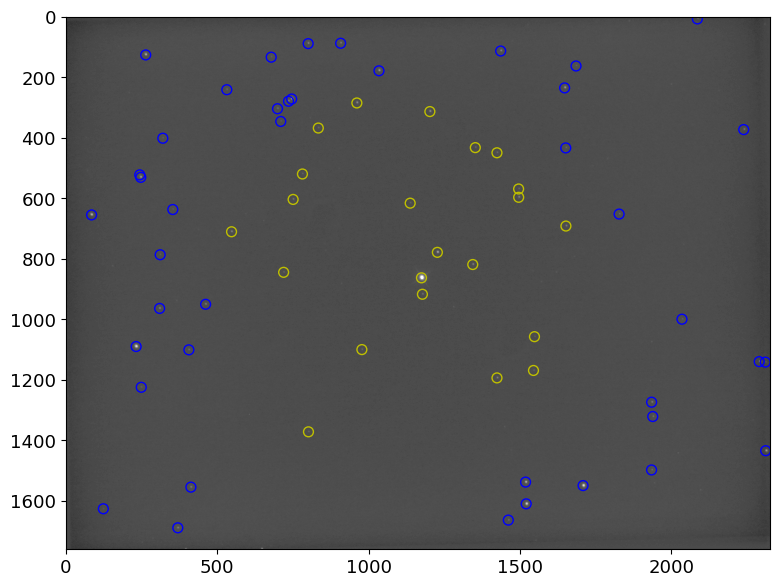

In [50]:


x1 = composite_df_stars['xcenter'][ind]
y1 = composite_df_stars['ycenter'][ind]

aper_radius = composite_df_stars['Apperature_radius (reduced pix)'][ind]

an_inner = composite_df_stars['Anulus_in_radius (reduced pix)'][ind]
an_outer = composite_df_stars['Anulus_out_radius (reduced pix)'][ind]

fig = plt.figure(figsize=(20,20))
        #ax1.cla()
ax1 = plt.subplot(1,2,1)
ax1.imshow(composite_image,cmap=my_cmap,norm=LogNorm(vmin=1,vmax=0.1*composite_image.max()))

for ind in composite_df_stars.index:
    if composite_df_stars['Normilsation_star_reason'][ind] == 'Default so still to do':
        circle1 = plt.Circle((composite_df_stars['xcenter'][ind],composite_df_stars['ycenter'][ind]),\
                             composite_df_stars['Anulus_out_radius (reduced pix)'][ind], color='y',fill=False)
        plt.gca().add_patch(circle1)
    else:
        circle1 = plt.Circle((composite_df_stars['xcenter'][ind],composite_df_stars['ycenter'][ind]),\
                             composite_df_stars['Anulus_out_radius (reduced pix)'][ind], color='b',fill=False)
        plt.gca().add_patch(circle1)


plt.show()
 


59 of 64
Saturated = 1.0
Magnitude: -5.042 +- -1.376
Name?  nan
What kind of object?  nan
1


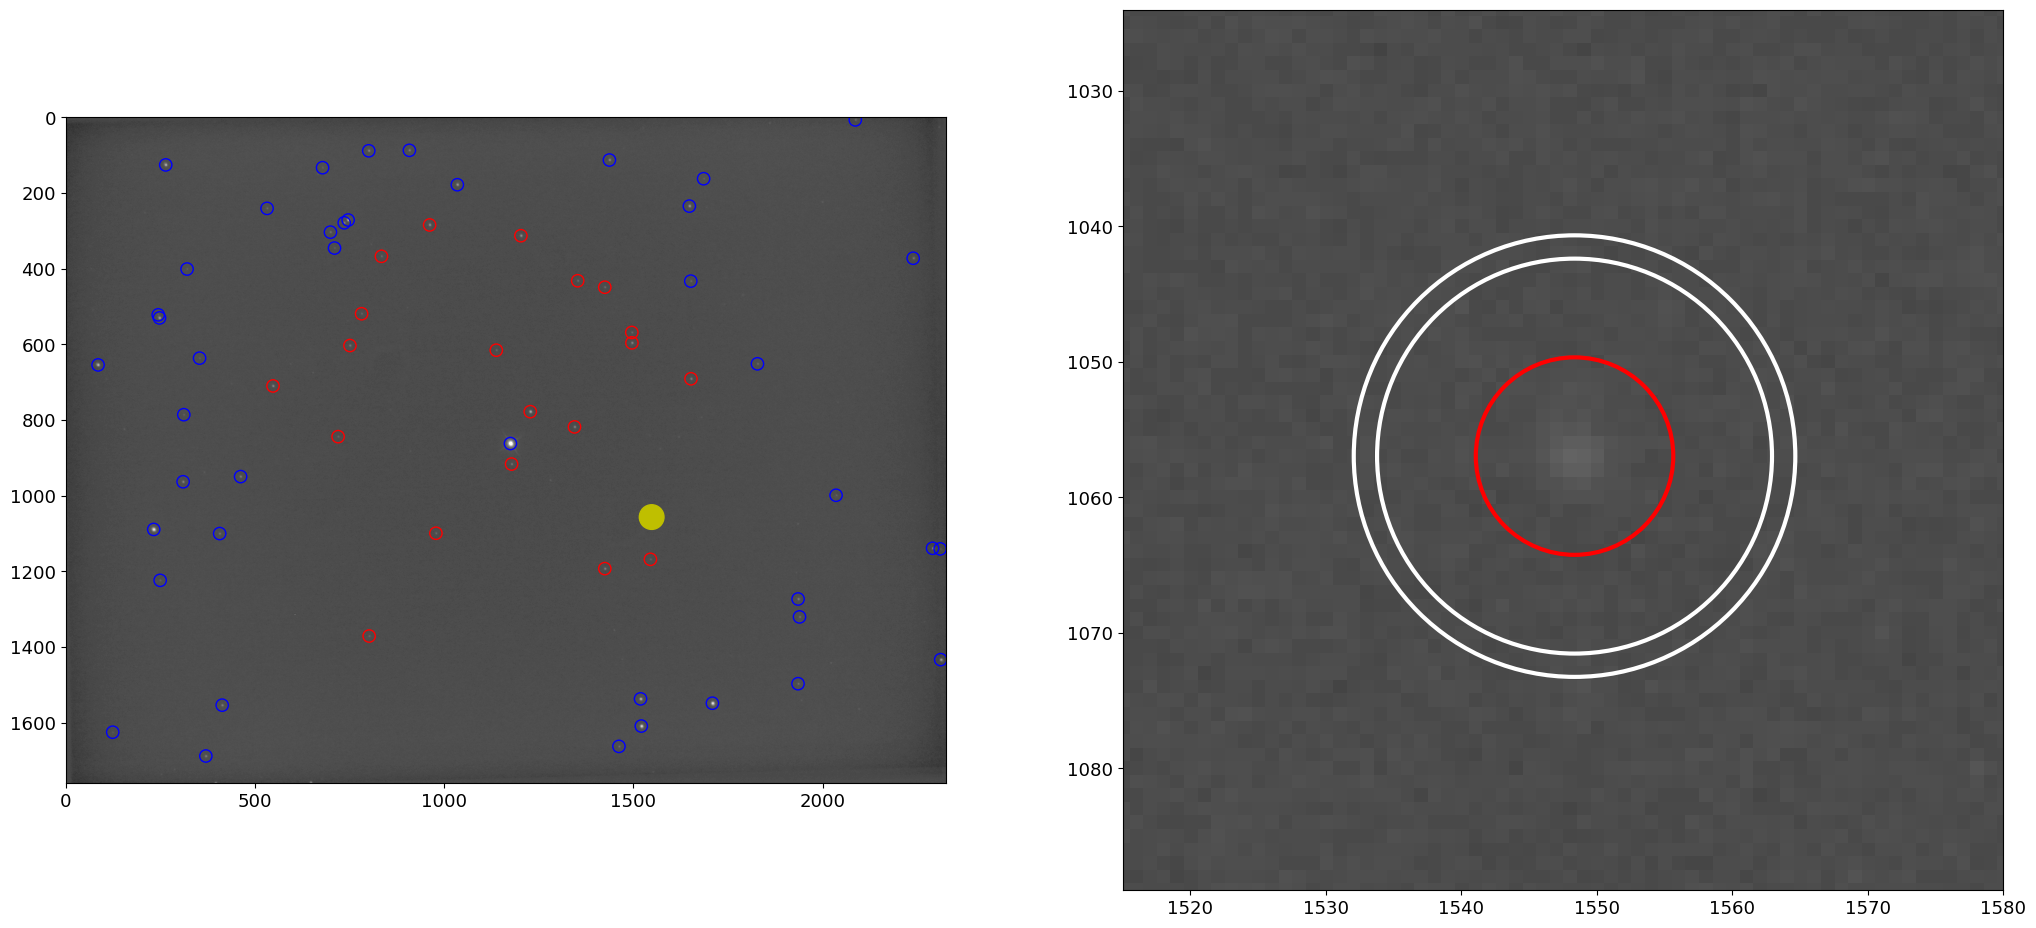

OK? y/nn
Why?feint
Normilsation star?  FALSE
Reason?  feint
Next!


In [52]:
fig = plt.figure(figsize=(20,22))

an_outer = composite_df_stars['Anulus_out_radius (reduced pix)'][0]
nopixels=an_outer*4

no_stars = len(composite_df_stars.index)

for ind in composite_df_stars.index:
    if  composite_df_stars['Normilsation_star_reason'][ind] == 'Default so still to do':
        clear_output(wait=True)


        print(str(ind) +' of '+ str(no_stars))
        print('Saturated =', composite_df_stars['Saturated'][ind])
        print('Magnitude: {0:.3f} +- {1:.3f}'.format(composite_df_stars['Source_Mag'][ind], composite_df_stars['Source_Mag_Error'][ind]))
        print('Name? ',composite_df_stars['MAIN_ID'][ind])
        print('What kind of object? ',composite_df_stars['OTYPE'][ind])



        x1 = composite_df_stars['xcenter'][ind]
        y1 = composite_df_stars['ycenter'][ind]

        aper_radius = composite_df_stars['Apperature_radius (reduced pix)'][ind]

        an_inner = composite_df_stars['Anulus_in_radius (reduced pix)'][ind]
        an_outer = composite_df_stars['Anulus_out_radius (reduced pix)'][ind]
        
        #######


        
        ######

        fig = plt.figure(figsize=(25,27))
        #ax1.cla()
        ax1 = plt.subplot(1,2,1)
        ax1.imshow(composite_image,cmap=my_cmap,norm=LogNorm(vmin=1,vmax=0.1*composite_image.max()))
        
        for ind2 in composite_df_stars.index:
            if composite_df_stars['Normilsation_star_reason'][ind2] == 'Default so still to do':
                circle1 = plt.Circle((composite_df_stars['xcenter'][ind2],composite_df_stars['ycenter'][ind2]),\
                             composite_df_stars['Anulus_out_radius (reduced pix)'][ind2], color='y',fill=False)
                plt.gca().add_patch(circle1)
            elif composite_df_stars['Normilsation_star'][ind2] == 'FALSE':
                circle1 = plt.Circle((composite_df_stars['xcenter'][ind2],composite_df_stars['ycenter'][ind2]),\
                             composite_df_stars['Anulus_out_radius (reduced pix)'][ind2], color='b',fill=False)
                plt.gca().add_patch(circle1)
            elif composite_df_stars['Normilsation_star_reason'][ind2] == 'All good':
                circle1 = plt.Circle((composite_df_stars['xcenter'][ind2],composite_df_stars['ycenter'][ind2]),\
                             composite_df_stars['Anulus_out_radius (reduced pix)'][ind2], color='r',fill=False)
                plt.gca().add_patch(circle1)
        
    

        circle4 = plt.Circle((composite_df_stars['xcenter'][ind],composite_df_stars['ycenter'][ind]), nopixels/2, color='y',fill='y')
        plt.gca().add_patch(circle4)

        plot_star = 1
        in_middle = 0
        if int(y1-nopixels/2) > 0:
            if int(y1+nopixels/2) < composite_image.shape[0]:
                if int(x1-nopixels/2) > 0:
                    if int(x1+nopixels/2) < composite_image.shape[1]:
                        in_middle = 1
        print(in_middle)

        if in_middle == 0:
            composite_df_stars['Normilsation_star'][ind] = 'FALSE'
            composite_df_stars['Normilsation_star_reason'][ind] = 'Too close to the edge'
            plot_star = 0

        if composite_df_stars['Saturated'][ind] == 'TRUE':
            composite_df_stars['Normilsation_star'][ind] = 'FALSE'
            composite_df_stars['Normilsation_star_reason'][ind] = 'Saturated'
            plot_star = 0

        if  composite_df_stars['OTYPE'][ind] in list_of_non_normilation_targets:
            composite_df_stars['Normilsation_star'][ind] = 'FALSE'
            composite_df_stars['Normilsation_star_reason'][ind] = 'NOt a constant star'
            plot_star = 0


        elif in_middle == 1:
            
            x1 = composite_df_stars['xcenter'][ind]
            y1 = composite_df_stars['ycenter'][ind]
            
            ax2 = plt.subplot(1,2,2)
            ax2.imshow(composite_image,cmap=my_cmap,norm=LogNorm(vmin=1,vmax=0.1*composite_image.max()))
            ax2.set(ylim=[int(y1+nopixels/2),int(y1-nopixels/2)])
            ax2.set(xlim=[int(x1-nopixels/2),int(x1+nopixels/2)])

            circle1 = plt.Circle((x1, y1), aper_radius, color='r',fill=False,lw=3)
            circle2 = plt.Circle((x1, y1), an_inner, color='w',fill=False,lw=3)
            circle3 = plt.Circle((x1, y1), an_outer, color='w',fill=False,lw=3)

            plt.gca().add_patch(circle1)
            plt.gca().add_patch(circle2)
            plt.gca().add_patch(circle3)

            plt.show()

            input1 = input('OK? y/n')

            if input1 == 'y':
              
                composite_df_stars['Normilsation_star'][ind] = 'TRUE'
                composite_df_stars['Normilsation_star_reason'][ind] = 'All good'

            else:
                composite_df_stars['Normilsation_star'][ind] = 'FALSE'
                input2 = input('Why?')
                composite_df_stars['Normilsation_star_reason'][ind] = input2
                
        print('Normilsation star? ', composite_df_stars['Normilsation_star'][ind])
        print('Reason? ', composite_df_stars['Normilsation_star_reason'][ind])

        composite_df_stars.to_csv(composite_photometry_file_normalisation)
        
        input('Next!')
        plt.show()